In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
comp = 'bluebook-for-bulldozers'

import kagglehub

path = kagglehub.competition_download(comp)
path = Path(path)

## Data preparation

In [3]:
df = pd.read_csv(path / 'TrainAndValid.csv', low_memory=False)

In [4]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

In [5]:
dep_variable = 'SalePrice'
df[dep_variable] = np.log(df[dep_variable])
df = add_datepart(df, 'saledate')

In [6]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

Choosing our own splits, to train model for predicting future not filling in gap data

In [7]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

cont,cat = cont_cat_split(df, 1, dep_var=dep_variable)

In [8]:
to = TabularPandas(
    df,
    procs = [Categorify, FillMissing],
    cat_names=cat,
    cont_names=cont,
    y_names=dep_variable,
    splits=splits
)

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,1,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09
1,2,1745,529,57,98,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,1,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09
2,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09
3,1,3716,1381,0,45,0,4,8,44,4,4,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139251,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1.305763e+09
4,3,4261,1538,0,0,0,0,40,32,3,3,0,1,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139253,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,0,490,160,108,0,0,5,13,44,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333344,1919201,21435,149,2.0,2005,0.0,2012,3,10,7,2,67,1.331078e+09
412694,0,491,160,108,63,0,5,17,9,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333345,1882122,21436,149,2.0,2005,0.0,2012,1,4,28,5,28,1.327709e+09
412695,0,490,160,108,0,0,5,13,9,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,1,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333347,1944213,21435,149,2.0,2005,0.0,2012,1,4,28,5,28,1.327709e+09
412696,0,490,160,108,0,0,5,13,44,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,1,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333348,1794518,21435,149,2.0,2006,0.0,2012,3,10,7,2,67,1.331078e+09


## Decision Tree

In [10]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,4
,min_impurity_decrease,0.0
,ccp_alpha,0.0


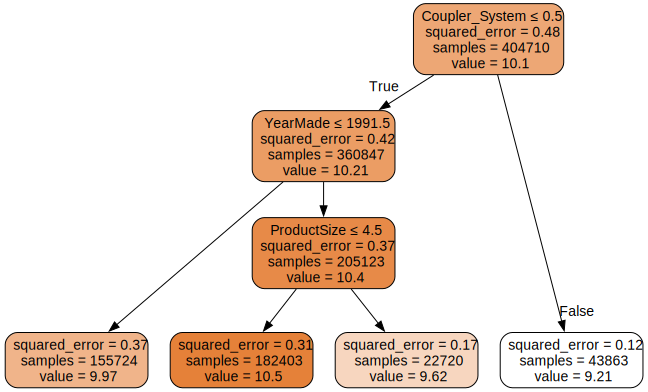

In [11]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [41]:
import dtreeviz

def showtree(tree):
    samp_idx = np.random.permutation(len(y))[:500]
    viz = dtreeviz.model(
        tree,
        xs.iloc[samp_idx],  # pandas.DataFrame
        y.iloc[samp_idx],  # pandas.Series
        target_name=dep_variable,
        feature_names=list(xs.columns),
    ) 
    return viz

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


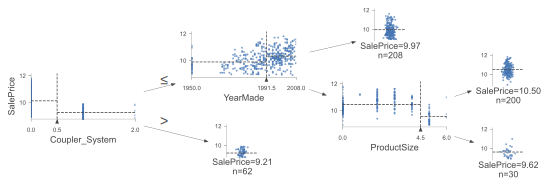

In [43]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

showtree(m).view(orientation='LR')

In [48]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,25
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [44]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [49]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.211706, 0.268776)

## Random forest

In [50]:
def random_forest(
    xs, 
    y, 
    n_estimators=40, 
    max_samples=200_000,
    max_features=0.5, 
    min_samples_leaf=5, 
    **kwargs
):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [138]:
forest = random_forest(xs, y)
m_rmse(forest, xs, y), m_rmse(forest, valid_xs, valid_y)

(0.171029, 0.233146)

In [74]:
preds = np.stack([e.predict(valid_xs) for e in forest.estimators_])
preds.shape

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: 

(40, 7988)

In [63]:
r_mse(forest.oob_prediction_, y)

0.210883

In [75]:
preds.std(0)

array([0.22604266, 0.11861944, 0.10820157, ..., 0.17308902, 0.12603418, 0.12927889])

In [139]:
len(df.columns), len(forest.feature_importances_)


imp_df = pd.DataFrame(
    {
        'cols': xs.columns,
        'imp' : forest.feature_importances_
     }
).sort_values('imp')

imp_columns = imp_df[imp_df['imp'] > 0.005].cols

xs_imp = xs[imp_columns]
valid_xs_imp = valid_xs[imp_columns]

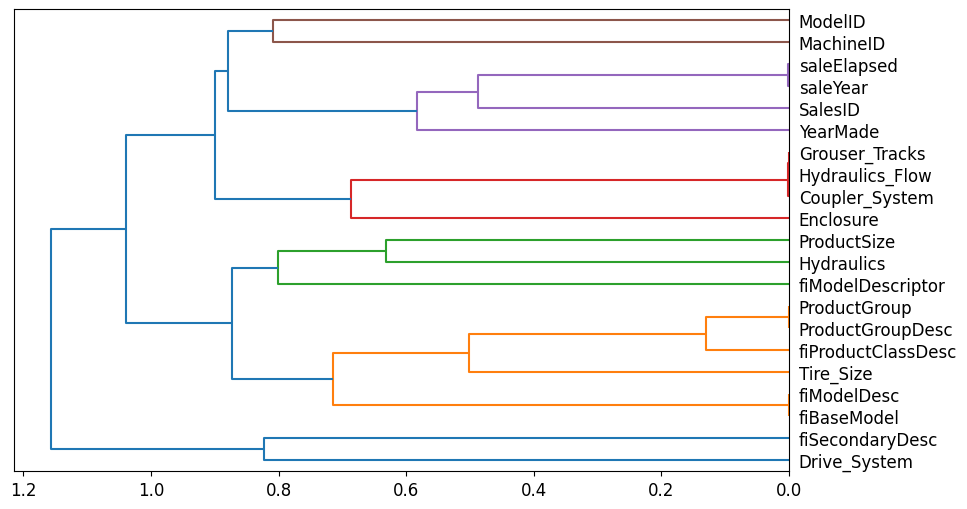

In [140]:
cluster_columns(xs_imp)

In [141]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [142]:
forest = random_forest(xs_final, y)
m_rmse(forest, xs_final, y), m_rmse(forest, valid_xs_final, valid_y)

(0.183342, 0.23274)

In [157]:
r_mse(forest.oob_prediction_, y)

0.215915

## Tree interpreter

In [143]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

rows = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(forest, rows.values)

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


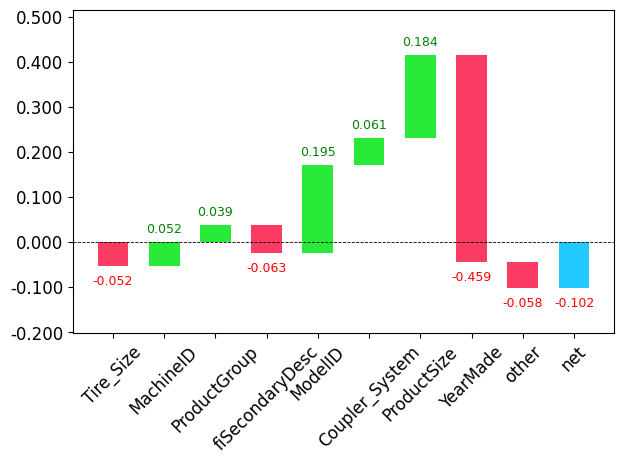

In [144]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Extrapolation

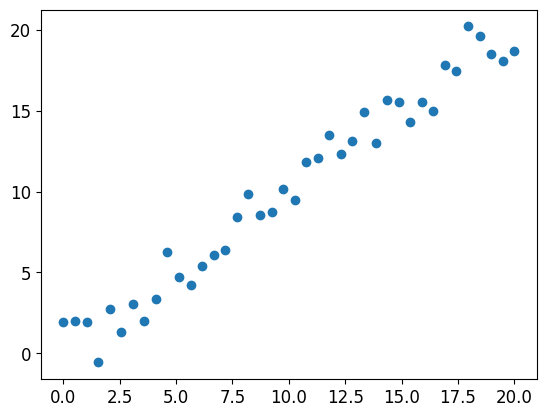

In [119]:
np.random.seed(42)
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [120]:
xs_lin = x_lin.unsqueeze(1)
xs_lin.shape

torch.Size([40, 1])

In [121]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

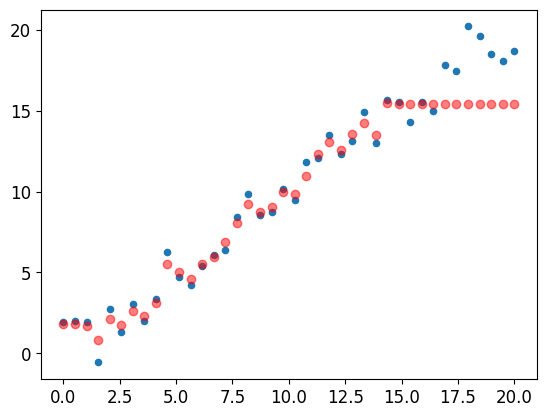

In [122]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

## Neural Networks on Tabular Data

In [124]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'] = df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_variable] = np.log(df_nn[dep_variable])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
xs_final_time = xs_final.drop(['SalesID','MachineID', 'fiModelDescriptor'], axis=1)
valid_xs_time = valid_xs_final.drop(['SalesID','MachineID', 'fiModelDescriptor'], axis=1)
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_variable]]

In [146]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_variable)

In [147]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [149]:
m2 = random_forest(xs_filt, y_filt)
m_rmse(m2, xs_filt, y_filt), m_rmse(m2, valid_xs_time, valid_y)

(0.177675, 0.229457)

In [150]:
cat_nn.remove('fiModelDescriptor')

In [151]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(
    df_nn_final, 
    procs_nn, 
    cat_nn, 
    cont_nn,
    splits=splits,
    y_names=dep_variable
)
dls = to_nn.dataloaders(1024)

In [152]:
y = to_nn.train.y
y.min(),y.max()

(np.float32(8.465899), np.float32(11.863583))

In [153]:
learn = tabular_learner(
    dls, 
    y_range=(8,12), 
    layers=[500,250],
    n_out=1, 
    loss_func=F.mse_loss
)

SuggestedLRs(valley=0.00019054606673307717)

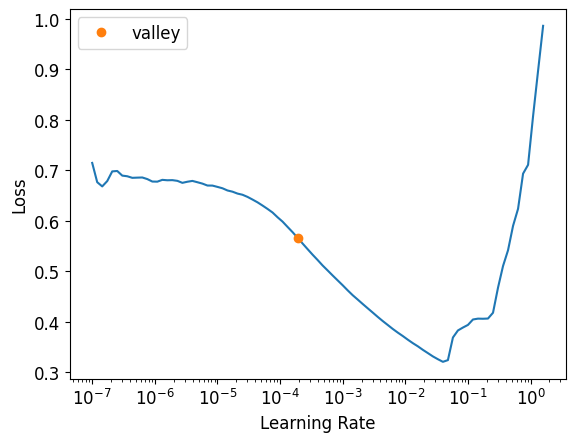

In [154]:
learn.lr_find()

In [155]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062178,0.067552,00:25
1,0.051404,0.062147,00:18
2,0.046382,0.056400,00:14
3,0.041826,0.054427,00:13
4,0.040222,0.052621,00:14


In [156]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.229392